# Homework 5: Parallel Bifurcation diagram
by Rustam Guseyn-zade ([link canvas](https://skoltech.instructure.com/courses/3546/users/9673))

## Table of contents
* [Bifurcation map in parallel](#Bifurcation-map-in-parallel)
* [Timings](#Timings)

In [1]:
# import needed libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import mpi4py
import time

## Bifurcation map in parallel

In [2]:
%%writefile bifurcation.py
# Create file bifurcation.py
import matplotlib.pyplot as plt
from mpi4py import MPI
import numpy as np


comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

xs_amount = 100000
r = np.linspace(0, 4.0, num=xs_amount)

chunk_size = xs_amount//size + 1
chunk_head = chunk_size * rank
chunk_tail = chunk_size * (rank + 1)
if chunk_tail > xs_amount:
    chunk_tail = xs_amount
    
x = np.random.rand((chunk_tail-chunk_head))
for i in range(1, 10000):
    inverted_x = 1 - x
    updated_x = np.multiply(x,r[chunk_head:chunk_tail])
    updated_x = np.multiply(updated_x, inverted_x)
    x = updated_x
print(f"process {rank}: from {chunk_head} to {chunk_tail}")
  
all_x_patched = comm.gather((chunk_head, x),root=0)

if rank == 0:
    all_x = []
    for x_patch in sorted(all_x_patched):
        all_x = np.append(all_x, x_patch[1])
    plt.figure(figsize=(12, 8))
    plt.title(r'Logistic map: $x_{n+1} = r x_{n} (1-x_{n}).$ ')
    plt.ylabel('x')
    plt.xlabel('r')
    plt.scatter(r, all_x, s=0.1)
    #plt.show()
    plt.savefig('bifurcation.png')

Overwriting bifurcation.py


In [3]:
!mpirun --allow-run-as-root -np 3 python3 bifurcation.py

process 1: from 33334 to 66668
process 2: from 66668 to 100000
process 0: from 0 to 33334


Resulting plot could be found on `bifurcation.png` file

## Timings

Text(0.5, 1.0, 'Bifurcation map mpi speedup')

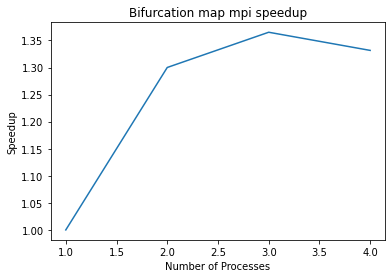

In [4]:
def measure_n_processes_time(processes_number, attempts=50):
    number_processes_time = []
    for i in range(attempts):
        start = time.time()
        !mpirun --allow-run-as-root -n {processes_number} python3 bifurcation.py >/dev/null 2>&1
        end = time.time()
        number_processes_time.append(end - start)
        print(f'measure attempt {i+1} from {attempts} for {processes_number} processes', end='\r')
    return sum(number_processes_time) / attempts

processes_times = [measure_n_processes_time(i) for i in range(1,5)]
speedups = [processes_times[0] / processes_times[i] for i in range(len(processes_times))]
plt.plot(range(1, 5), speedups)
plt.ylabel('Speedup')
plt.xlabel('Number of Processes')
plt.title('Bifurcation map mpi speedup')